# Benchmarking translations

In [1]:
import evaluate

c:\code\anaconda3\envs\transaltion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Подгружаем метрики METEOR, BLEU, ROUGE

In [2]:
meteor_score = evaluate.load('meteor')
bleu_score = evaluate.load('bleu')
rouge_score = evaluate.load('rouge')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Модель для метрики COMET

In [3]:
from comet.models import download_model, load_from_checkpoint
model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path).to('cuda')

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\Тимур\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\2760a223ac957f30acfb18c8aa649b01cf1d75f2\checkpoints\model.ckpt`
Encoder model frozen.
c:\code\anaconda3\envs\transaltion\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


Кастомная функция токенизации для русского языка

In [4]:
from nltk.tokenize import word_tokenize

def word_tokenize_rus(text):
    return word_tokenize(text.lower(), language='russian')

Функция для подсчета всех метрик

In [5]:
def eval_translation(model_name, eng_texts, translation, references, batch_size=8):
    list_ref = [[ref] for ref in references]
    print(list_ref)
    bleu_results = bleu_score.compute(references=list_ref, predictions=translation, tokenizer=word_tokenize_rus)
    rouge_results = rouge_score.compute(references=list_ref, predictions=translation, tokenizer=word_tokenize_rus)
    meteor_results = meteor_score.compute(references=list_ref, predictions=translation)
    comet_data = [{"src": src, "mt": mt, "ref": ref} for src, mt, ref in zip(eng_texts, translation, references)]
    comet_results = comet_model.predict(samples=comet_data, batch_size=batch_size)
    comet_results = comet_results['system_score']
    return {'model': model_name, 'bleu': bleu_results['bleu'], 'meteor': meteor_results['meteor'],
            'rouge1': rouge_results['rouge1'], 'rouge2': rouge_results['rouge2'], 'rougeL': rouge_results['rougeL'],
            'comet': comet_results}
    

### Загрузка наборов данных

In [6]:
import pandas as pd

from datasets import load_dataset

Загрузка набора данных FloRes

In [7]:
flores_dataset = load_dataset("facebook/flores", "rus_Cyrl", trust_remote_code=True)
flores_df = flores_dataset['devtest'].to_pandas()
flores_rus_sentences = flores_dataset['devtest'].to_pandas()['sentence'].tolist()
flores_dataset = load_dataset("facebook/flores", "eng_Latn", trust_remote_code=True)
flores_eng_sentences = flores_dataset['devtest'].to_pandas()['sentence'].tolist()
flores_data = pd.DataFrame(columns=['rus_Cyrl', 'eng_Latn'], data=list(zip(flores_rus_sentences, flores_eng_sentences)))

In [8]:
flores_data.head()

,rus_Cyrl,eng_Latn
0,"""Теперь у нас есть четырёхмесячные мыши, у кот...","""We now have 4-month-old mice that are non-dia..."
1,Согласно предупреждению доктора Эхуда Ура (Ehu...,"Dr. Ehud Ur, professor of medicine at Dalhousi..."
2,"Как и некоторые другие эксперты, он сомневаетс...","Like some other experts, he is skeptical about..."
3,"В понедельник Сара Даниус, постоянный секретар...","On Monday, Sara Danius, permanent secretary of..."
4,"Даниус заявил: ""Сейчас мы ничего не делаем. Я ...","Danius said, ""Right now we are doing nothing. ..."


In [98]:
flores_data.to_csv('eng_ru_flores.csv')

In [9]:
flores_data = pd.read_csv('eng_ru_flores.csv')

Загрузка набора данных NTREX

In [10]:
ntrex_dataset = load_dataset("xianf/NTREX", "ru", trust_remote_code=True)
ntrex_rus_sentences = ntrex_dataset['train']['text']
ntrex_dataset = load_dataset("xianf/NTREX", "en", trust_remote_code=True)
ntrex_eng_sentences = ntrex_dataset['train']['text']
ntrex_data = pd.DataFrame(columns=['rus_Cyrl', 'eng_Latn'], data=list(zip(ntrex_rus_sentences, ntrex_eng_sentences)))

In [11]:
ntrex_data.head()

,rus_Cyrl,eng_Latn
0,Члены Ассамблеи Уэльса не хотят «походить на м...,Welsh AMs worried about 'looking like muppets'
1,Среди некоторых членов Национальной ассамблеи ...,There is consternation among some AMs at a sug...
2,Проблематичное решение связано с планами измен...,It has arisen because of plans to change the n...
3,Членов Ассамблеи из разных политических партий...,AMs across the political spectrum are worried ...
4,"Один из лейбористов, выражая мнение своей парт...","One Labour AM said his group was concerned ""it..."


In [118]:
ntrex_data.to_csv('eng_ru_ntrex.csv')

In [12]:
ntrex_data = pd.read_csv('eng_ru_ntrex.csv')

## mitre

In [18]:
import torch
from torch.utils.data import DataLoader

In [11]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("naist-nlp/mitre_913m", trust_remote_code=True, use_fast=False, cache_dir="new_cache_dir/")
model = AutoModel.from_pretrained("naist-nlp/mitre_913m", trust_remote_code=True, cache_dir="new_cache_dir/")

In [12]:
device = 'cuda'

In [13]:
model.to(device)

MitreForConditionalGeneration(
  (model): MitreModel(
    (decoder): MitreDecoder(
      (embed_tokens): MitreScaledWordEmbedding(160025, 1280, padding_idx=1)
      (src_embed_positions): MitreSinusoidalPositionalEmbedding()
      (register_embed_positions): MitreSinusoidalPositionalEmbedding()
      (tgt_embed_positions): MitreSinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-35): 36 x MitreDecoderLayer(
          (self_attn): MitreSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          

In [14]:
def translate_batch(batch, model):
    src_tokens = tokenizer.encode_source_tokens_to_input_ids(batch, target_language="ru")
    generated_tokens = model.generate(src_tokens.cuda(), num_beams=2)
    results = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return results

flores

In [15]:
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(flores_data['eng_Latn'].tolist(), batch_size=5, shuffle=False):
        translations.extend(translate_batch(batch, model))
        torch.cuda.empty_cache()

In [16]:
flores_data['mitre'] = translations

In [17]:
flores_data.to_csv('eng_ru_flores.csv')

In [22]:
flores_mitre_res = eval_translation('mitre', flores_data['eng_Latn'].tolist(),flores_data['mitre'].tolist() ,flores_data['rus_Cyrl'].tolist())

[['"Теперь у нас есть четырёхмесячные мыши, у которых больше нет диабета", — добавил он.'], ['Согласно предупреждению доктора Эхуда Ура (Ehud Ur), профессора медицины в Университете Дэлхаузи в Галифаксе (Новая Шотландия) и председателя клинико-научного отдела Канадской диабетической ассоциации, исследования все еще находятся на начальной стадии.'], ['Как и некоторые другие эксперты, он сомневается, что диабет излечим, отмечая, что эти открытия не относятся к людям, у которых уже развился диабет 1 типа.'], ['В понедельник Сара Даниус, постоянный секретарь Нобелевского комитета по литературе при Шведской Академии, публично заявила во время передачи на шведской радиостанции Sveriges о том, что комитет, которому не удалось связаться с Бобом Диланом напрямую и сообщить ему, что он выиграл Нобелевскую премию по литературе за 2016 год, прекращает попытки выйти с ним на связь.'], ['Даниус заявил: "Сейчас мы ничего не делаем. Я звонил и отправлял электронные письма его ближайшему сотруднику и п

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 127/127 [00:13<00:00,  9.22it/s]


In [23]:
flores_mitre_res

{'model': 'mitre',
 'bleu': 0.3195996848462344,
 'meteor': 0.5618668942200588,
 'rouge1': 0.6148208908740918,
 'rouge2': 0.3858329684584724,
 'rougeL': 0.5873416518429799,
 'comet': 0.8890083165095729}

ntrex

In [24]:
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(ntrex_data['eng_Latn'].tolist(), batch_size=5, shuffle=False):
        translations.extend(translate_batch(batch, model))
        torch.cuda.empty_cache()

In [25]:
ntrex_data['mitre'] = translations

In [26]:
ntrex_data.to_csv('eng_ru_ntrex.csv')

In [27]:
ntrex_mitre_res = eval_translation('mitre', ntrex_data['eng_Latn'].tolist(),ntrex_data['mitre'].tolist() ,ntrex_data['rus_Cyrl'].tolist())

[['Члены Ассамблеи Уэльса не хотят «походить на маппетов»'], ['Среди некоторых членов Национальной ассамблеи зреет недовольство предложением принять для их наименования аббревиатуру MWP (от англ. Member of the Welsh Parliament\xa0— член Парламента Уэльса).'], ['Проблематичное решение связано с планами изменить название Ассамблеи на Парламент Уэльса.'], ['Членов Ассамблеи из разных политических партий беспокоят возможные шутки с этой аббревиатурой.'], ['Один из лейбористов, выражая мнение своей партии, высказал обеспокоенность по поводу того, что новая аббревиатура «рифмуется Twp и Pwp».'], ['Для наших читателей не из Уэльса: на валлийском twp означает «тупица», а pwp\xa0— «какашка».'], ['По словам члена Ассамблеи из Партии Уэльса, его организация в целом «осталась недовольна» и предложила другие варианты.'], ['Представители консервативной партии «не возражают» против новой аббревиатуры, но при этом отмечают, что MWP близко по написанию к слову Muppet (маппет).'], ['В этом контексте бук

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 250/250 [00:27<00:00,  8.95it/s]


In [28]:
ntrex_mitre_res

{'model': 'mitre',
 'bleu': 0.3485445044015682,
 'meteor': 0.5512298389263409,
 'rouge1': 0.6093227975351723,
 'rouge2': 0.3872818985520354,
 'rougeL': 0.577611521439507,
 'comet': 0.8601846409160373}

## NLLB

In [29]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-1.3B", trust_remote_code=True, use_fast=False, cache_dir="new_cache_dir/")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-1.3B", trust_remote_code=True, cache_dir="new_cache_dir/")

In [30]:
model.to(device)

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-23): 24 x M2M100EncoderLayer(
          (self_attn): M2M100SdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=1024, bias=True)
   

In [31]:
def translate_batch(batch, model):
    src_tokens = tokenizer(batch, return_tensors='pt')
    for key in src_tokens:
        src_tokens[key] = src_tokens[key].cuda()
    generated_tokens = model.generate(**src_tokens, forced_bos_token_id=tokenizer.convert_tokens_to_ids("rus_Cyrl"), max_length=100)
    results = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    return [''.join(results)]

flores

In [34]:
import torch
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(flores_data['eng_Latn'].tolist(), batch_size=1, shuffle=False):
        translations.extend(translate_batch(batch, model))
        torch.cuda.empty_cache()

In [35]:
flores_data['nllb-1.3'] = translations

In [36]:
flores_data.to_csv('eng_ru_flores.csv')

In [37]:
flores_nllb_res = eval_translation('nllb-1.3', flores_data['eng_Latn'].tolist(),flores_data['nllb-1.3'].tolist() ,flores_data['rus_Cyrl'].tolist())

[['"Теперь у нас есть четырёхмесячные мыши, у которых больше нет диабета", — добавил он.'], ['Согласно предупреждению доктора Эхуда Ура (Ehud Ur), профессора медицины в Университете Дэлхаузи в Галифаксе (Новая Шотландия) и председателя клинико-научного отдела Канадской диабетической ассоциации, исследования все еще находятся на начальной стадии.'], ['Как и некоторые другие эксперты, он сомневается, что диабет излечим, отмечая, что эти открытия не относятся к людям, у которых уже развился диабет 1 типа.'], ['В понедельник Сара Даниус, постоянный секретарь Нобелевского комитета по литературе при Шведской Академии, публично заявила во время передачи на шведской радиостанции Sveriges о том, что комитет, которому не удалось связаться с Бобом Диланом напрямую и сообщить ему, что он выиграл Нобелевскую премию по литературе за 2016 год, прекращает попытки выйти с ним на связь.'], ['Даниус заявил: "Сейчас мы ничего не делаем. Я звонил и отправлял электронные письма его ближайшему сотруднику и п

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 127/127 [07:41<00:00,  3.64s/it]


In [38]:
flores_nllb_res

{'model': 'nllb-1.3',
 'bleu': 0.2913702250025962,
 'meteor': 0.5292204637161153,
 'rouge1': 0.5918643417458734,
 'rouge2': 0.35705900290120574,
 'rougeL': 0.5638539311196518,
 'comet': 0.8799308800532413}

ntrex

In [39]:
import torch
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(ntrex_data['eng_Latn'].tolist(), batch_size=1, shuffle=False):
        translations.extend(translate_batch(batch, model))
        torch.cuda.empty_cache()

In [40]:
ntrex_data['nllb-1.3'] = translations

In [41]:
ntrex_data.to_csv('eng_ru_ntrex.csv')

In [42]:
ntrex_nllb_res = eval_translation('nllb-1.3', ntrex_data['eng_Latn'].tolist(),ntrex_data['nllb-1.3'].tolist() ,ntrex_data['rus_Cyrl'].tolist())

[['Члены Ассамблеи Уэльса не хотят «походить на маппетов»'], ['Среди некоторых членов Национальной ассамблеи зреет недовольство предложением принять для их наименования аббревиатуру MWP (от англ. Member of the Welsh Parliament\xa0— член Парламента Уэльса).'], ['Проблематичное решение связано с планами изменить название Ассамблеи на Парламент Уэльса.'], ['Членов Ассамблеи из разных политических партий беспокоят возможные шутки с этой аббревиатурой.'], ['Один из лейбористов, выражая мнение своей партии, высказал обеспокоенность по поводу того, что новая аббревиатура «рифмуется Twp и Pwp».'], ['Для наших читателей не из Уэльса: на валлийском twp означает «тупица», а pwp\xa0— «какашка».'], ['По словам члена Ассамблеи из Партии Уэльса, его организация в целом «осталась недовольна» и предложила другие варианты.'], ['Представители консервативной партии «не возражают» против новой аббревиатуры, но при этом отмечают, что MWP близко по написанию к слову Muppet (маппет).'], ['В этом контексте бук

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 250/250 [15:25<00:00,  3.70s/it]


In [43]:
ntrex_nllb_res

{'model': 'nllb-1.3',
 'bleu': 0.2917389756998917,
 'meteor': 0.49619042487083037,
 'rouge1': 0.5637880118900305,
 'rouge2': 0.331572084418606,
 'rougeL': 0.5335081681144929,
 'comet': 0.8533497090392191}

## wmt19

In [13]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer
mname = "facebook/wmt19-en-ru"
tokenizer = FSMTTokenizer.from_pretrained(mname, cache_dir="new_cache_dir/")
model = FSMTForConditionalGeneration.from_pretrained(mname, cache_dir="new_cache_dir/")

input = "Hello"
input_ids = tokenizer.encode(input, return_tensors="pt")
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-ru and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer
mname = "facebook/wmt19-en-ru"
tokenizer = FSMTTokenizer.from_pretrained(mname)
model = FSMTForConditionalGeneration.from_pretrained(mname)

input = "Machine learning is great, isn't it?"
input_ids = tokenizer.encode(input, return_tensors="pt")
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded) # Машинное обучение - это здорово, не так ли?

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-ru and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\code\anaconda3\envs\transaltion\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Тимур\.cache\huggingface\hub\models--facebook--wmt19-en-ru. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Deve

Машинное обучение - это здорово, не так ли?


In [15]:
model.to('cuda')

FSMTForConditionalGeneration(
  (model): FSMTModel(
    (encoder): FSMTEncoder(
      (embed_tokens): Embedding(31640, 1024, padding_idx=1)
      (embed_positions): SinusoidalPositionalEmbedding(1026, 1024, padding_idx=1)
      (layers): ModuleList(
        (0-5): 6 x EncoderLayer(
          (self_attn): Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )

In [88]:
def translate_batch(batch, model):
    src_tokens = tokenizer.encode(batch, return_tensors='pt')
    generated_tokens = model.generate(src_tokens.cuda(), num_beams=2)
    results = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
    return results

In [58]:
input_ids = tokenizer.encode(q[:5], return_tensors="pt")
outputs = model.generate(input_ids.to('cuda'))
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded) # Машинное обучение - это здорово, не так ли?

Ошибочно.


flores

In [89]:
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(flores_data['eng_Latn'].tolist(), shuffle=False):
        translations.append(translate_batch(batch[0], model))
        torch.cuda.empty_cache()

In [92]:
flores_data['wmt'] = translations

In [93]:
flores_data.to_csv('eng_ru_flores.csv')

In [94]:
flores_wmt_res = eval_translation('wmt', flores_data['eng_Latn'].tolist(),flores_data['wmt'].tolist() ,flores_data['rus_Cyrl'].tolist())

[['"Теперь у нас есть четырёхмесячные мыши, у которых больше нет диабета", — добавил он.'], ['Согласно предупреждению доктора Эхуда Ура (Ehud Ur), профессора медицины в Университете Дэлхаузи в Галифаксе (Новая Шотландия) и председателя клинико-научного отдела Канадской диабетической ассоциации, исследования все еще находятся на начальной стадии.'], ['Как и некоторые другие эксперты, он сомневается, что диабет излечим, отмечая, что эти открытия не относятся к людям, у которых уже развился диабет 1 типа.'], ['В понедельник Сара Даниус, постоянный секретарь Нобелевского комитета по литературе при Шведской Академии, публично заявила во время передачи на шведской радиостанции Sveriges о том, что комитет, которому не удалось связаться с Бобом Диланом напрямую и сообщить ему, что он выиграл Нобелевскую премию по литературе за 2016 год, прекращает попытки выйти с ним на связь.'], ['Даниус заявил: "Сейчас мы ничего не делаем. Я звонил и отправлял электронные письма его ближайшему сотруднику и п

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 127/127 [00:15<00:00,  8.38it/s]


In [96]:
flores_wmt_res

{'model': 'wmt',
 'bleu': 0.30166370243859436,
 'meteor': 0.541181252417181,
 'rouge1': 0.5965529007015697,
 'rouge2': 0.3659740427325241,
 'rougeL': 0.5676589185638359,
 'comet': 0.8673131807225024}

ntrex

In [97]:
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(ntrex_data['eng_Latn'].tolist(), shuffle=False):
        translations.append(translate_batch(batch[0], model))
        torch.cuda.empty_cache()

In [98]:
ntrex_data['wmt'] = translations

In [99]:
ntrex_data.to_csv('eng_ru_ntrex.csv')

In [100]:
ntrex_wmt_res = eval_translation('wmt', ntrex_data['eng_Latn'].tolist(),ntrex_data['wmt'].tolist() ,ntrex_data['rus_Cyrl'].tolist())

[['Члены Ассамблеи Уэльса не хотят «походить на маппетов»'], ['Среди некоторых членов Национальной ассамблеи зреет недовольство предложением принять для их наименования аббревиатуру MWP (от англ. Member of the Welsh Parliament\xa0— член Парламента Уэльса).'], ['Проблематичное решение связано с планами изменить название Ассамблеи на Парламент Уэльса.'], ['Членов Ассамблеи из разных политических партий беспокоят возможные шутки с этой аббревиатурой.'], ['Один из лейбористов, выражая мнение своей партии, высказал обеспокоенность по поводу того, что новая аббревиатура «рифмуется Twp и Pwp».'], ['Для наших читателей не из Уэльса: на валлийском twp означает «тупица», а pwp\xa0— «какашка».'], ['По словам члена Ассамблеи из Партии Уэльса, его организация в целом «осталась недовольна» и предложила другие варианты.'], ['Представители консервативной партии «не возражают» против новой аббревиатуры, но при этом отмечают, что MWP близко по написанию к слову Muppet (маппет).'], ['В этом контексте бук

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 250/250 [00:29<00:00,  8.45it/s]


In [101]:
ntrex_mitre_res

{'model': 'wmt',
 'bleu': 0.2898672502241676,
 'meteor': 0.4967412356464306,
 'rouge1': 0.5582872688249367,
 'rouge2': 0.3287582925537283,
 'rougeL': 0.527968441578009,
 'comet': 0.8502567615220114}

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

100%|██████████| 25.0G/25.0G [2:09:04<00:00, 3.47MB/s]  

Extracting files...


Path to dataset files: C:\Users\Тимур\.cache\kagglehub\datasets\awsaf49\coco-2017-dataset\versions\2


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eeshawn/flickr30k")

print("Path to dataset files:", path)

100%|██████████| 4.08G/4.08G [20:21<00:00, 3.59MB/s]

Extracting files...


Path to dataset files: C:\Users\Тимур\.cache\kagglehub\datasets\eeshawn\flickr30k\versions\1


In [ ]:
 C:\Users\Тимур\.cache\kagglehub\datasets\eeshawn\flickr30k\versions\1\flickr30k_images

In [102]:
import pandas as pd
df = pd.read_parquet("captions.parquet")

In [103]:
df

,image_name,comment_number,comment,rus_cap
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,Двое молодых парней с лохматыми волосами смотр...
5,10002456.jpg,0,Several men in hard hats are operating a giant...,Несколько человек в жестких шляпах управляют г...
10,1000268201.jpg,0,A child in a pink dress is climbing up a set o...,Ребенок в розовом платье поднимается по лестнице.
15,1000344755.jpg,0,Someone in a blue shirt and hat is standing on...,Кто-то в синей рубашке и шляпе стоит на лестни...
20,1000366164.jpg,0,Two men one in a gray shirt one in a black s...,"Двое мужчин, один в серой рубашке, другой в че..."
...,...,...,...,...
158890,997338199.jpg,0,Woman writing on a pad in room with gold deco...,Женщина пишет на блокноте в комнате с украшенн...
158895,997722733.jpg,0,A person in a red shirt climbing up a rock fac...,"Человек в красной рубашке, поднимающийся по ск..."
158900,997876722.jpg,0,Two male construction workers are working on a...,Двое строителей-мужчин работают на улице возле...
158905,99804383.jpg,0,An older busker in glasses plays an Eastern st...,Пожилой музыкант в очках играет на восточном с...


In [170]:
q = df.sample(1)
q

,image_name,comment_number,comment,rus_cap
75620,3542927866.jpg,0,A man in a long-sleeved shirt riding a yellow...,Мужчина в рубашке с длинным рукавом едет на же...


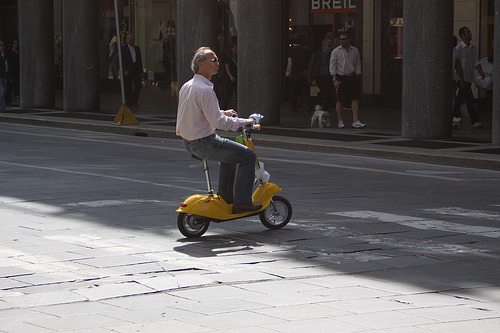

In [171]:
from PIL import Image
img =  Image.open("1/flickr30k_images/3542927866.jpg").convert("RGB")
img

A man in a long-sleeved shirt  riding a yellow moped across a street .
Мужчина в рубашке с длинным рукавом едет на желтом мопеде по улице.


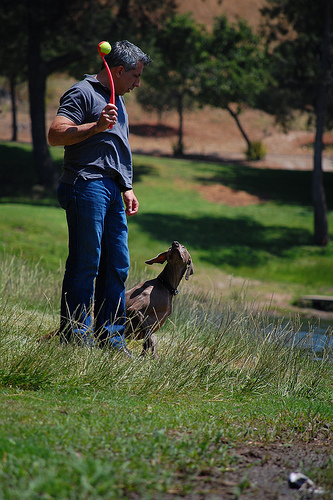

In [172]:
from PIL import Image
img =  Image.open("1/flickr30k_images/2587846523.jpg").convert("RGB")
print(q['comment'][75620])
print(q['rus_cap'][75620])
img

In [148]:
q['comment'][94980]

'A young man in a green shirt is jumping with his skateboard over three steps in front of a skyscraper .'

In [149]:
q['rus_cap'][94980]

'Молодой человек в зеленой рубашке прыгает со своим скейтбордом по трем ступенькам перед небоскребом.'

In [1]:
import evaluate

c:\code\anaconda3\envs\transaltion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
meteor_score = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from datasets import load_dataset

In [4]:
ru_data = load_dataset("xianf/NTREX", "ru", trust_remote_code=True)

In [5]:
en_data = load_dataset("xianf/NTREX", "en", trust_remote_code=True)

In [6]:
ru_df = ru_data['train'].to_pandas()['text'].tolist()

In [7]:
en_df = en_data['train'].to_pandas()['text'].tolist()

In [ ]:
df = dataset['devtest'].to_pandas()

In [ ]:
rus_sentences = df['sentence'].tolist()

In [ ]:
eng_dataset = load_dataset("facebook/flores", "eng_Latn", trust_remote_code=True)

Generating dev split: 997 examples [00:00, 21627.06 examples/s]
Generating devtest split: 1012 examples [00:00, 21701.15 examples/s]


In [ ]:
eng_sentences = eng_dataset['devtest'].to_pandas()['sentence'].tolist()

In [9]:
import pandas as pd
all_data = pd.DataFrame(columns=['rus_Cyrl', 'eng_Latn'], data=list(zip(ru_df, en_df)))

In [10]:
all_data.head()

,rus_Cyrl,eng_Latn
0,Члены Ассамблеи Уэльса не хотят «походить на м...,Welsh AMs worried about 'looking like muppets'
1,Среди некоторых членов Национальной ассамблеи ...,There is consternation among some AMs at a sug...
2,Проблематичное решение связано с планами измен...,It has arisen because of plans to change the n...
3,Членов Ассамблеи из разных политических партий...,AMs across the political spectrum are worried ...
4,"Один из лейбористов, выражая мнение своей парт...","One Labour AM said his group was concerned ""it..."


In [28]:
all_data.to_csv('eng_ru_flores.csv')

In [29]:
import pandas as pd

In [30]:
all_data = pd.read_csv('eng_ru_flores.csv')

In [31]:
rus_sentences = all_data['rus_Cyrl'].tolist()

In [ ]:
eng_sentences = all_data['eng_Latn'].tolist()

## mtranslate

In [ ]:
import tqdm
from mtranslate import translate
translations = [translate(sent, to_language='ru', from_language='en') for sent in tqdm.tqdm(eng_sentences)]

100%|██████████| 1012/1012 [12:29<00:00,  1.35it/s]


In [ ]:
google_api_metric = meteor_score.compute(references=rus_sentences, predictions=translations)

In [ ]:
google_api_metric

{'meteor': np.float64(0.5098248528574553)}

## mitre

In [151]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("naist-nlp/mitre_913m", trust_remote_code=True, use_fast=False, cache_dir="new_cache_dir/")
model = AutoModel.from_pretrained("naist-nlp/mitre_913m", trust_remote_code=True, cache_dir="new_cache_dir/")

In [152]:
device = 'cuda'

In [153]:
model.to(device)

MitreForConditionalGeneration(
  (model): MitreModel(
    (decoder): MitreDecoder(
      (embed_tokens): MitreScaledWordEmbedding(160025, 1280, padding_idx=1)
      (src_embed_positions): MitreSinusoidalPositionalEmbedding()
      (register_embed_positions): MitreSinusoidalPositionalEmbedding()
      (tgt_embed_positions): MitreSinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-35): 36 x MitreDecoderLayer(
          (self_attn): MitreSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          

In [154]:
def translate_batch(batch, model):
    src_tokens = tokenizer.encode_source_tokens_to_input_ids(batch, target_language="ru")
    generated_tokens = model.generate(src_tokens.cuda(), num_beams=2)
    results = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return results

In [15]:
import torch

In [16]:
from torch.utils.data import DataLoader

In [17]:
import torch
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(en_df, batch_size=5, shuffle=False):
        translations.extend(translate_batch(batch, model))
        torch.cuda.empty_cache()

In [18]:
len(translations)

1997

In [19]:
meteor_score.compute(references=ru_df, predictions=translations)

{'meteor': np.float64(0.5512298389263409)}

## NLLB

In [46]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-1.3B", trust_remote_code=True, use_fast=False, cache_dir="new_cache_dir/")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-1.3B", trust_remote_code=True, cache_dir="new_cache_dir/")

In [47]:
model.to(device)

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-23): 24 x M2M100EncoderLayer(
          (self_attn): M2M100SdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=1024, bias=True)
   

In [48]:
def translate_batch(batch, model):
    src_tokens = tokenizer(batch, return_tensors='pt')
    for key in src_tokens:
        src_tokens[key] = src_tokens[key].cuda()
    generated_tokens = model.generate(**src_tokens, forced_bos_token_id=tokenizer.convert_tokens_to_ids("rus_Cyrl"), max_length=100)
    results = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    return [''.join(results)]

In [ ]:
translations[:15]

['"', 'У', ' ', 'н', 'а', 'с', ' ', 'т', 'е', 'п', 'е', 'р', 'ь', ' ', 'е']

In [49]:
import torch
from tqdm import tqdm
translations = []
with torch.no_grad():
    for batch in DataLoader(en_df, batch_size=1, shuffle=False):
        translations.extend(translate_batch(batch, model))
        torch.cuda.empty_cache()

KeyboardInterrupt: 

In [ ]:
meteor_score.compute(references=rus_sentences, predictions=translations)

IndexError: list index out of range

## wmt19

In [136]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer
mname = "wmt19"
tokenizer = FSMTTokenizer.from_pretrained(mname)
model = FSMTForConditionalGeneration.from_pretrained(mname)

input = "Machine learning is great, isn't it?"
input_ids = tokenizer.encode(input, return_tensors="pt")
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded) # Машинное обучение - это здорово, не так ли?

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at wmt19 and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Машинное обучение - это здорово, не так ли?


In [149]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer
mname = "facebook/wmt19-en-ru"
tokenizer = FSMTTokenizer.from_pretrained('wmt19')
model = FSMTForConditionalGeneration.from_pretrained('wmt19')

input = "I don't know."
input_ids = tokenizer.encode(input, return_tensors="pt")
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at wmt19 and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [150]:
print(decoded)

Я не знаю.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

100%|██████████| 25.0G/25.0G [2:09:04<00:00, 3.47MB/s]  

Extracting files...


Path to dataset files: C:\Users\Тимур\.cache\kagglehub\datasets\awsaf49\coco-2017-dataset\versions\2


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eeshawn/flickr30k")

print("Path to dataset files:", path)

100%|██████████| 4.08G/4.08G [20:21<00:00, 3.59MB/s]

Extracting files...


Path to dataset files: C:\Users\Тимур\.cache\kagglehub\datasets\eeshawn\flickr30k\versions\1


In [ ]:
 C:\Users\Тимур\.cache\kagglehub\datasets\eeshawn\flickr30k\versions\1\flickr30k_images

In [ ]:
import pandas as pd
df = pd.read_parquet("captions.parquet")

In [ ]:
df

,image_name,comment_number,comment,rus_cap
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,Двое молодых парней с лохматыми волосами смотр...
5,10002456.jpg,0,Several men in hard hats are operating a giant...,Несколько человек в жестких шляпах управляют г...
10,1000268201.jpg,0,A child in a pink dress is climbing up a set o...,Ребенок в розовом платье поднимается по лестнице.
15,1000344755.jpg,0,Someone in a blue shirt and hat is standing on...,Кто-то в синей рубашке и шляпе стоит на лестни...
20,1000366164.jpg,0,Two men one in a gray shirt one in a black s...,"Двое мужчин, один в серой рубашке, другой в че..."
...,...,...,...,...
158890,997338199.jpg,0,Woman writing on a pad in room with gold deco...,Женщина пишет на блокноте в комнате с украшенн...
158895,997722733.jpg,0,A person in a red shirt climbing up a rock fac...,"Человек в красной рубашке, поднимающийся по ск..."
158900,997876722.jpg,0,Two male construction workers are working on a...,Двое строителей-мужчин работают на улице возле...
158905,99804383.jpg,0,An older busker in glasses plays an Eastern st...,Пожилой музыкант в очках играет на восточном с...


In [ ]:
q = df.sample(1)
q

,image_name,comment_number,comment,rus_cap
58770,3173928684.jpg,0,Two white long-haired dogs play roughly with e...,Две длинношерстные белые собаки играют друг с ...


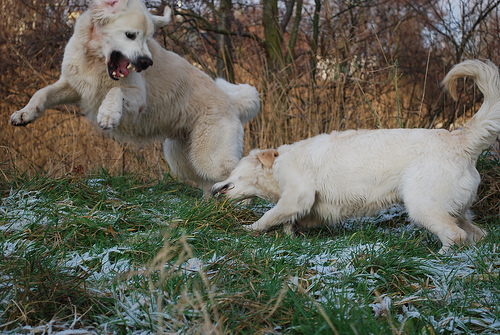

In [ ]:
from PIL import Image
img =  Image.open("1/flickr30k_images/3173928684.jpg").convert("RGB")
img

In [ ]:
q['comment'][58770]

'Two white long-haired dogs play roughly with each other in tall grass with snow .'

In [ ]:
q['rus_cap'][58770]

'Две длинношерстные белые собаки играют друг с другом в высокой траве со снегом.'